# Processing of the Dataset for Multi-label classification 

-  In this notebook I will explain how the dataset generation for the multi-label task was performed

## Dependencies

-  The python packages mentioned below.
-  One additional package (also mentioned below) that I created which is available in the repository. 
-  The audio files from the dataset, arranged in the 10 original folders.

In [2]:
# Lets import packages
import santiago_data_preprocessing as prep
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import wavfile
import imp
from scipy import signal
import time
import pandas as pd
import wave
import os
from sklearn.model_selection import train_test_split
import struct
import IPython.display as ipd
import random
import librosa
import soundfile as sf


# Defining the functions we will need to process the audio files <br>

In [6]:
def get_files_and_resample(sampling_rate_new, desired_length_seconds, noise = False, noise_all = False, db_SNR = 0):
    
# A function to import the original files, resample them and get also their Class Id
    # Inputs:
        # sampling_rate_new - the new sampling rate we want to apply to all audio files
        # desired_length_seconds - length we want the audio files to have
    # Outputs:
        # x, matrix with dimensions (sampling_rate_new*duration, number_of_examples)
        # y, vector with dimensions (1,number_of_examples)
    
    startpath = os.path.abspath("UrbanSound8K_Original\\audio")
    list_with_file_names1 = os.listdir(startpath) 


    duration_samples = int(desired_length_seconds * sampling_rate_new)
    y = []
    x =[]
    index = 0
    
    for file1 in list_with_file_names1:  #Loop over the different folders (fold1, fold2,...)

        if file1 == '.DS_Store':         #Ommit this file
            continue
            
        completePath1 = os.path.join(startpath,file1) 

        list_with_file_names2 = os.listdir(completePath1)
        
           
        counter = [0,0,0,0,0,0,0,0,0,0]
        
#         if file1 != 'fold9':
#             continue

        for file2 in reversed(list_with_file_names2): #Loop over the different audio files in the different folders (fold1,...)

            if file2 == '.DS_Store':        #Ommit this file
                continue
            
                
            completePath2 = os.path.join(completePath1,file2)
            
            index += 1
            
            class_id = file2.split("-")[1]     #Extract the class id, e.g. 9031-3-1-0.wav --> Class id = 3
            counter[int(class_id)] += 1
            
            number = 28  #Max number of audio samples per folder and per class

            if (counter[0] > number and int(class_id) == 0):
                continue
            elif (counter[1] > number and int(class_id) == 1):
                continue
            elif (counter[2] > number and int(class_id) == 2):
                continue
            elif (counter[3] > number and int(class_id) == 3):
                continue
            elif (counter[4] > number and int(class_id) == 4):
                continue
            elif (counter[5] > number and int(class_id) == 5):
                continue
            elif (counter[6] > number and int(class_id) == 6):
                continue
            elif (counter[7] > number and int(class_id) == 7):
                continue
            elif (counter[8] > number and int(class_id) == 8):
                continue
            elif (counter[9] > number and int(class_id) == 9):
                continue


            input_file, sampling_rate_orig = sf.read(completePath2) #Gets input file and sampling rate (sf supports 24-bit inputs)
            
            if input_file.ndim == 2:
                input_file = input_file[:,0]    #Takes only channel1
                       
            inputfile_resampled = librosa.resample(input_file, sampling_rate_orig, sampling_rate_new) #Resampling
            
            if len(inputfile_resampled) < duration_samples:
                x_files = prep.zero_pad(inputfile_resampled, sampling_rate_new, desired_length_seconds, 
                                  noise = noise, noise_all = noise_all, db_SNR = db_SNR, index=index)
#                 x_files = prep.extend_file(inputfile_resampled, sampling_rate_new, desired_length_seconds)


            elif noise == True:
                x_files, noise_scaled = prep.add_noise(inputfile_resampled[0:duration_samples],db_SNR, index=index)
            
            else:
                x_files = inputfile_resampled[0:duration_samples]

            y.append(class_id)
            x.append(x_files)   #Appends to a list of arrays
            
    x2 = np.array(x)
    
    x = np.transpose(x2)        #Creates an array from the list of arrays, and transposes it to get the desired shape
    y = np.array(y).astype(int) #Convert the list to an array

    
    return x, y #, counting_files 


# Processing the audio files

In [7]:
#SELECT PARAMETERS
sampling_rate_new = 22050
duration = 3  #          # duration that I want the audio files to have (in seconds)
mel_bands = 60       # mel frequency bands to extract
window_size = 1024     # for the STFT (in samples)
hop_length = 512   # for the STFT (in samples)

db_SNR = 2     #SNR pink noise

t = time.time()

# Extract the 28*10*45 audio files from the 10 folders
x, y = get_files_and_resample(sampling_rate_new, duration, noise = False, noise_all = False, db_SNR = db_SNR)

# Split them into training, validation and test sets, otherwise the mixing gets messy
x_train = x[:, 0:2240] 
y_train = y[0:2240]

x_val = x[:, 2240:2520]
y_val = y[2240:2520]

x_test = x[:, 2520:2800]
y_test = y[2520:2800]

class_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Order them to split them into train/test/val sets
x_ordered_train, y_ordered_train = prep.order_files(x_train, y_train, class_ids)
x_ordered_val, y_ordered_val = prep.order_files(x_val, y_val, class_ids)
x_ordered_test, y_ordered_test = prep.order_files(x_test, y_test, class_ids)

# Mix them
x_mixed_train, y_mixed_train = prep.mix_files(x_ordered_train, y_ordered_train, examples_per_class = 28*8)
x_mixed_val, y_mixed_val = prep.mix_files(x_ordered_val, y_ordered_val, examples_per_class = 28)
x_mixed_test, y_mixed_test = prep.mix_files(x_ordered_test, y_ordered_test, examples_per_class = 28)

# Extract features
features_train = prep.get_mel_spectrogram(x_mixed_train, sampling_rate_new, mel_bands, window_size, hop_length)
features_val = prep.get_mel_spectrogram(x_mixed_val, sampling_rate_new, mel_bands, window_size, hop_length)
features_test = prep.get_mel_spectrogram(x_mixed_test, sampling_rate_new, mel_bands, window_size, hop_length)

# Convert y to one-hot  
y_labels = np.concatenate((y_mixed_train, y_mixed_val, y_mixed_test))
y_train_one_hot = prep.one_hot_encode_mine(y_labels)
y_train_one_hot = prep.one_hot_encode_mine(y_mixed_train)

# Concatenate features
features = np.concatenate((features_train, features_val, features_test), axis = 0)

elapsed = time.time() - t

# Let's hear and visualize an example

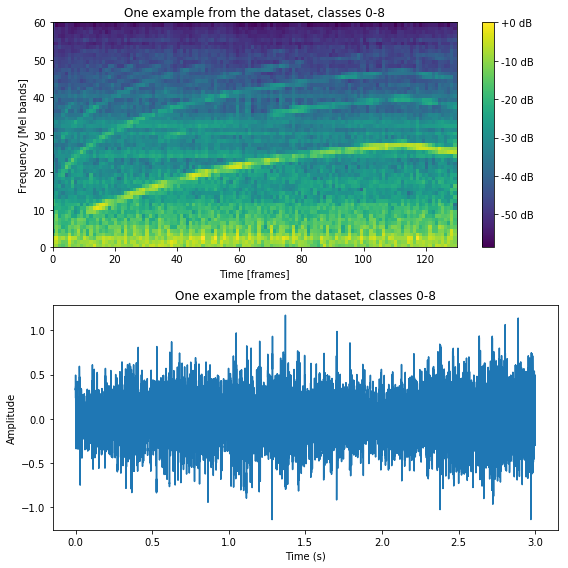

In [12]:
#Idx of example to plot
example = 7  

#Take features samples of one example
Sxx = features_train[:,:,example]

class_names = ['Air conditioner','Car horn','Children pl.','Dog bark','Drilling','Engine','Gun shot','Jackhammer','Siren','Street music']

#Create figure and two subplots for the two pictures
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8))

#Generate the mel-spectrogram plot
fig.colorbar(axes[0].pcolormesh(Sxx), format='%+2.0f dB', ax = axes[0])
axes[0].set(title = 'One example from the dataset, classes %s' %y_mixed_train[example], ylabel = 'Frequency [Mel bands]', xlabel = 'Time [frames]')

#Generate the signal amplitude plot
time_vector = np.arange(0,x_mixed_train.shape[0],1) / sampling_rate_new
axes[1].plot(time_vector, x_mixed_train[:,example])
axes[1].set(title = 'One example from the dataset, classes %s' %y_mixed_train[example], xlabel = 'Time (s)', ylabel = 'Amplitude')

#Adjust the subplots
plt.tight_layout()

#Write the audio file to then play it. Change the folder!
sf.write(r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav', x_mixed_train[:,example], sampling_rate_new)
ipd.display(ipd.Audio(filename = r'C:\Users\Santiago\deep-machine-learning\Sounds_for_notebooks\Ejemplin.wav'))


## A more visual example of how the mixing of the different classes is performed

In [23]:
x_list = []
y_list = []

number_classes = 3
examples_per_class = 5
examples = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5']


for index in range(number_classes):

    for i in range(examples_per_class):

        for ii in range(number_classes):

            
            if (index * examples_per_class + i) >= (ii * examples_per_class + i):
                continue
            

            x_list.append(examples[index * examples_per_class + i] + examples[ii * examples_per_class + i])
            
        
print(x_list)


['A1B1', 'A1C1', 'A2B2', 'A2C2', 'A3B3', 'A3C3', 'A4B4', 'A4C4', 'A5B5', 'A5C5', 'B1C1', 'B2C2', 'B3C3', 'B4C4', 'B5C5']
